# Optimizing SR on Ideal Topography

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import params_ideal as params

from fun_ideal import calc_flood_height, generate_groups, calc_group_vol, calc_group_h, get_wall_heights
from ideal_damage import Damage
from topo_ideal import Topo

In [2]:
topo_file = "Input/ideal_topo_gp_points_1.csv"
storm_file = "SurgeData/0-waterlevel_w.csv"
div_data_file = "Input/ideal_div_data.csv"
time_file = "SurgeData/0-time_w.csv"
damage_table_file = "Input/damage_table.csv"

In [3]:
surge = pd.read_csv(storm_file).values
surge_time = pd.read_csv(time_file).values
damage_table = pd.read_csv(damage_table_file)


Topo = Topo(topo_file=topo_file)
Damage = Damage(damage_table_file)

In [4]:
# generate groups
#groups = generate_groups(Topo.div_data)

segment_l = 100
wall_height = np.zeros(Topo.shore_height.size)

# Infinite Water Travel
(Water level is assumed to reach equilibrium)

# Single Ensemble Uniform Allocation
Allocates same height across the topo (Note: might not make difference if on uniform topo)

In [5]:
params.travel_dist = 2

divs_allocate = list(range(18))
groups = generate_groups(Topo.div_data)

positions = []
for i, p in enumerate(wall_height):
    if Topo.all_divs[i] in divs_allocate:
        positions.append(i)
        
h_start = 0
h_end = 3
h_num = 100

points = []
wall_height[positions] = h_start

           0             1             2             3             4  \
0   0.000000  0.000000e+00  2.044442e+08  2.044442e+08  37824.933093   
1   0.030303  2.162345e+07  1.907336e+08  2.123571e+08  22723.724272   
2   0.060606  4.324691e+07  1.880609e+08  2.313078e+08  22573.964662   
3   0.090909  6.487036e+07  1.831508e+08  2.480211e+08  22573.964662   
4   0.121212  8.649382e+07  1.783425e+08  2.648363e+08  22573.964662   
..       ...           ...           ...           ...           ...   
95  2.878788  2.054228e+09  0.000000e+00  2.054228e+09      0.000000   
96  2.909091  2.075852e+09  0.000000e+00  2.075852e+09      0.000000   
97  2.939394  2.097475e+09  0.000000e+00  2.097475e+09      0.000000   
98  2.969697  2.119099e+09  0.000000e+00  2.119099e+09      0.000000   
99  3.000000  2.140722e+09  0.000000e+00  2.140722e+09      0.000000   

               5             6             7              8             9  
0   1.896732e+06  17735.317501  1.600308e+06  155715.012924

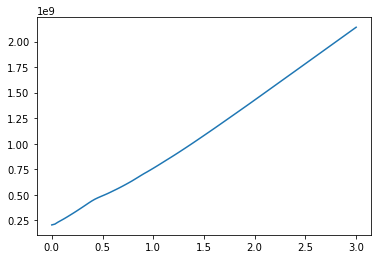

In [6]:
for h in np.linspace(h_start, h_end, num=h_num):
    wall_height[:] = 0
    wall_height[positions] = h

    height_div, volume_div = calc_flood_height(Topo, surge, surge_time, wall_height, positions)

    # calculate group volumes
    volume_grouped = calc_group_vol(groups, volume_div)

    # get height in each group
    surge_peak = np.amax(surge, axis=1)
    height_grouped = calc_group_h(Topo, groups, volume_grouped, surge_peak)

    #Damage
    dmg = Damage.calc_damage(height_grouped)
    cost_dmg = np.sum(dmg)
    cost_wall = np.sum(49212 * wall_height * segment_l)
    cost_tot = cost_dmg + cost_wall

    points.append([h, cost_wall, cost_dmg, cost_tot, volume_div[0,0], volume_div[4,0], volume_div[0, 10], volume_div[4,10], volume_grouped[0,0], volume_grouped[4,0]])
    
df = pd.DataFrame(points)
df.to_csv("Output/full_uniform_wall_opt.csv")
print(df)
plt.plot(df.iloc[:,0], df.iloc[:,3])

# Single Ensemble Even Allocation
Allocates to even out topo

In [7]:
params.travel_dist = 999


groups = generate_groups(Topo.div_data)
        
h_max = 3
dh = 0.01


min_height = np.min(Topo.shore_height)
N = int(np.max(np.ceil((h_max - min_height)/dh), 0))

        0             1             2             3             4  \
0    1.90  0.000000e+00  2.048367e+08  2.048367e+08  37824.933093   
1    1.91  4.679520e+07  1.912067e+08  2.380019e+08  21056.579778   
2    1.92  4.827156e+07  1.879352e+08  2.362067e+08  18498.360961   
3    1.93  4.979681e+07  1.841735e+08  2.339704e+08  16118.827944   
4    1.94  5.132238e+07  1.812223e+08  2.325447e+08  13926.740883   
..    ...           ...           ...           ...           ...   
105  2.95  4.487707e+08  1.944356e+07  4.682142e+08      0.000000   
106  2.96  4.545285e+08  1.906900e+07  4.735975e+08      0.000000   
107  2.97  4.602863e+08  1.868901e+07  4.789753e+08      0.000000   
108  2.98  4.660441e+08  1.830301e+07  4.843471e+08      0.000000   
109  2.99  4.718293e+08  1.790058e+07  4.897299e+08      0.000000   

                5             6             7              8             9  
0    1.896732e+06  17735.317501  1.600308e+06  582635.545413  3.819258e+07  
1    1.322091e+06

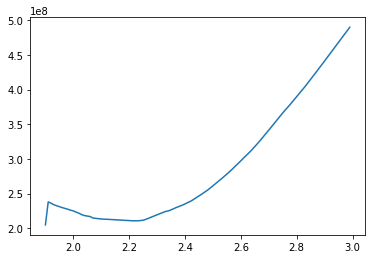

In [8]:
points = []
for n in range(N):
    height = min_height + n*dh

    pos, wall_heights = get_wall_heights(Topo, height) 

    height_div, volume_div = calc_flood_height(Topo, surge, surge_time, wall_heights, pos)

    # calculate group volumes
    volume_grouped = calc_group_vol(groups, volume_div)

    # get height in each group
    surge_peak = np.amax(surge, axis=1)
    height_grouped = calc_group_h(Topo, groups, volume_grouped, surge_peak)

    #Damage
    dmg = Damage.calc_damage(height_grouped)
    cost_dmg = np.sum(dmg)
    cost_wall = np.sum(49212 * wall_heights * segment_l)
    cost_tot = cost_dmg + cost_wall

    points.append([height, cost_wall, cost_dmg, cost_tot, volume_div[0,0], volume_div[4,0], volume_div[0, 10], volume_div[4,10], volume_grouped[0,0], volume_grouped[4,0]])
    
df = pd.DataFrame(points)
df.to_csv("Output/full_even_wall_opt.csv")
print(df)
plt.plot(df.iloc[:,0], df.iloc[:,3])